TEST LOADER FOR PHOIBOS 150 DATA

Typical structure 
/2020/01 January/Day 10/Raw Data/8874

Withing the folder of the scan number there is an info.txt and a scan
In THE AVG FOLDER there is a set of images, averaged over every acquisition cycle
IN THE RAW FOLDER there are single acquisition cycles (difference: in EPFL we added the "save every n cycle function"
this RAW folder also contains a "LUT.txt" file

In [2]:
#test the os package
import os

#get current directory
workingdir=os.getcwd()
#print(workingdir)
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
print("example data path= ",exampledatapath)
#this folders contains the AVG folder with the data, an info.txt vector and a scan vector
#filelist

#navigate to the image folder, for EPFL in the \AVG subfolder of the data (note that single scan cycles for partial load are in another subfolder - to be checked with Laurenz)
avgimagepath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159\AVG'))
print("AVG images path= ",avgimagepath)
rawimagelist=os.listdir(avgimagepath)
#alternatively join the paths
#avgimagepath=os.path.join(exampledatapath,'AVG') 


example data path=  C:\Users\Michele\OneDrive\Documenti\GitHub\specsanalyzer-1\tests\data\dataEPFL\2020\02 February\Day 17\Raw Data\9159
AVG images path=  C:\Users\Michele\OneDrive\Documenti\GitHub\specsanalyzer-1\tests\data\dataEPFL\2020\02 February\Day 17\Raw Data\9159\AVG


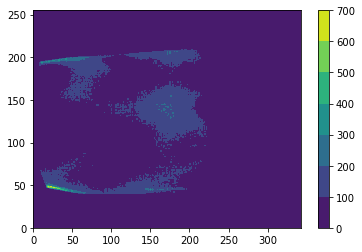

In [3]:
import numpy as np
import matplotlib.pyplot as plt
fname=os.path.join(avgimagepath,rawimagelist[0]) 
numpy_array = np.loadtxt(fname, delimiter="\t")

h = plt.contourf(numpy_array)
plt.colorbar()
#plt.xlim(120,150)
#plt.ylim(150,200)

one of the first operations should be to filter the image to remove the grid via FFT filtering

In [4]:
#load the module and import functions for reading the parameter table from the calib2d file
from importlib import reload
import specsanalyzer.convert
from specsanalyzer.convert import ParametersTable
reload(specsanalyzer.convert)
from specsanalyzer.convert import GetParameters
reload(specsanalyzer.convert)



<module 'specsanalyzer.convert' from 'c:\\users\\michele\\onedrive\\documenti\\github\\specsanalyzer-1\\specsanalyzer\\convert.py'>

In [5]:
#GET THE CALIBRATION FILE NAME FROM THE EXAMPLE FOLDER
calib2dfilename=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\phoibosEPFL.txt'))
#GET THE INFO FILE NAME FROM THE EXAMPLE FOLDER, SCAN 9159
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
str_match = list(filter(lambda x: 'info.txt' in x, filelist))
infofilename=os.path.join(exampledatapath,str_match[0]) 

calibrationmatrixfull=ParametersTable(calib2dfilename)


In [6]:
calibrationmatrixinterp=GetParameters(infofilename,calib2dfilename)

In [8]:
#let's make and test the  polynomial fit
ek=10
ep=20
eshift=np.array([-0.05,0,0.05])
currentdamatrix=calibrationmatrixinterp
print(type(eshift))
da_energy=eshift*ep+ek*np.ones(eshift.shape)

def calculate_polynomial_Coef_Da(ek,ep,eshift,currentdamatrix):
    
    #get the Das from the damatrix
    #da1=currentdamatrix[0][:]
    #da3=currentdamatrix[1][:]
    #da5=currentdamatrix[2][:]
    #da7=currentdamatrix[3][:]

    #calcualte the energy values for each da, given the eshift
    da_energy=eshift*ep+ek*np.ones(eshift.shape)

    #create the polinomial coeffiecient matrix, each is a third order polinomial 
    
    dapolymatrix=np.zeros(currentdamatrix.shape)

    for i in range(0,currentdamatrix.shape[0]):
        #igor uses the fit poly 3, which should be a parabola
        dapolymatrix[i][:]=np.polyfit(da_energy, currentdamatrix[i][:], 2).transpose()
    return dapolymatrix

dapolymatrix=calculate_polynomial_Coef_Da(ek,ep,eshift,currentdamatrix)

<class 'numpy.ndarray'>


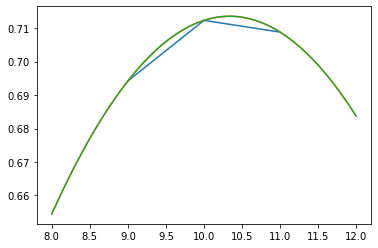

In [10]:
polcoef = np.polyfit(da_energy, currentdamatrix[0][:], 2)

plt.plot(da_energy,currentdamatrix[0][:])

energy_full=np.linspace(ek-ep*0.1,ek+ep*0.1,128)
polval=np.polyval(polcoef,energy_full)
polval2=np.polyval(dapolymatrix[0][:],energy_full)
plt.plot(energy_full,polval)
plt.plot(energy_full,polval2)

In [11]:
from specsanalyzer.convert import calculate_polynomial_coef_da
reload(specsanalyzer.convert)

<module 'specsanalyzer.convert' from 'c:\\users\\michele\\onedrive\\documenti\\github\\specsanalyzer-1\\specsanalyzer\\convert.py'>

In [12]:
dapolymatrix2=calculate_polynomial_coef_da(ek,ep,eshift,currentdamatrix)
dapolymatrix-dapolymatrix2

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

//~~~~~~~~~~~~~~~~~~~~~~~~~~~
function MCP_Position_mm(Ek, Ang)
Variable Ek, Ang

	NVAR aInner=root:Data:tmpData:Analyser:aInner
	Wave D1=root:Data:tmpData:Analyser:D1_coef
	Wave D3=root:Data:tmpData:Analyser:D3_coef
	Wave D5=root:Data:tmpData:Analyser:D5_coef
	Wave D7=root:Data:tmpData:Analyser:D7_coef

	if( abs(Ang) <= aInner)
		return zInner(Ek, Ang)
	else
		return sign(Ang)*(zInner(Ek, aInner) + (abs(Ang)-aInner)*zInner_Diff(Ek, aInner))
	endif
end

//~~~~~~~~~~~~~~~~~~~~~~~~~~~
// returns distance of given angle from center of MCP in mm, at the given energy
function zInner(Ek, Ang)
Variable Ek, Ang

	Wave D1=root:Data:tmpData:Analyser:D1_coef
	Wave D3=root:Data:tmpData:Analyser:D3_coef
	Wave D5=root:Data:tmpData:Analyser:D5_coef
	Wave D7=root:Data:tmpData:Analyser:D7_coef

	return poly(D1, Ek )*(Ang) + 10^-2*poly(D3, Ek )*(Ang)^3 + 10^-4*poly(D5, Ek )*(Ang)^5 + 10^-6*poly(D7, Ek )*(Ang)^7
end

//~~~~~~~~~~~~~~~~~~~~~~~~~~~
function zInner_Diff(Ek, Ang)
Variable Ek, Ang

	Wave D1=root:Data:tmpData:Analyser:D1_coef
	Wave D3=root:Data:tmpData:Analyser:D3_coef
	Wave D5=root:Data:tmpData:Analyser:D5_coef
	Wave D7=root:Data:tmpData:Analyser:D7_coef

	return poly(D1, Ek ) + 3*10^-2*poly(D3, Ek )*(Ang)^2 + 5*10^-4*poly(D5, Ek )*(Ang)^4 + 7*10^-6*poly(D7, Ek )*(Ang)^6
end


In [87]:
#let's now calculate the mcp_position_mm and zinner functions

def zinner(ek,angle,dapolymatrix):
    #poly(D1, Ek )*(Ang) + 10^-2*poly(D3, Ek )*(Ang)^3 + 10^-4*poly(D5, Ek )*(Ang)^5 + 10^-6*poly(D7, Ek )*(Ang)^7
    result=0
    for i in range(0,dapolymatrix.shape[0]):
        #igor uses the fit poly 3, which should be a parabola
        result=result+ 10**(-(2*i))*angle**(1+2*i)*np.polyval(dapolymatrix[i][:],ek)
        
    return result

def zinner_diff(ek,angle,dapolymatrix):
    #poly(D1, Ek ) + 3*10^-2*poly(D3, Ek )*(Ang)^2 + 5*10^-4*poly(D5, Ek )*(Ang)^4 + 7*10^-6*poly(D7, Ek )*(Ang)^6
    result=0
    for i in range(0,dapolymatrix.shape[0]):
        #igor uses the fit poly 3, which should be a parabola
        result=result+ (2*i+1)*10**(-(2*i))*angle**(2*i)*np.polyval(dapolymatrix[i][:],ek)
        
    return result


def mcp_position_mm(ek,angle,ainner,dapolymatrix):
    
    mask=np.greater_equal(np.abs(anglemesh),ainner)
   
    result=np.zeros(angle.shape)#ideally has to be evaluated on a mesh

    result[angletest[0]][angletest[1]]=zinner(ek,angle,dapolymatrix)-(np.sign(angle)*zinner(ek,angle,dapolymatrix)+(abs(angle)-ainner)*zinner_diff(ek,angle,dapolymatrix))
    #result.reshape(angle.shape)
    result=result+np.sign(angle)*zinner(ek,angle,dapolymatrix)+(abs(angle)-ainner)*zinner_diff(ek,angle,dapolymatrix)
    
    return result
#if np.greater_equal(np.abs(angle),ainner) : #values larger than the ainner have a different treatment
#    result= zinner(ek,angle,dapolymatrix)
#else:
#    result= np.sign(angle)*zinner(ek,angle,dapolymatrix) + (abs(angle)-ainner)*zinner_diff(ek,angle,dapolymatrix)

In [88]:
from numpy import angle


#mcp_position_mm(1,1,15,dapolymatrix)

angles=np.linspace(-18,18,1024)
energies=np.linspace(10,20,2048)

ainner=15

anglemesh,energymesh=np.meshgrid(angles,energies)
mask=np.greater_equal(np.abs(anglemesh),ainner)
select_indices = np.where(  )
testimage=mcp_position_mm(energymesh,anglemesh,15,dapolymatrix)

# seems hard to vectorize in this implementation...
#anglemesh[[np.greater_equal(np.abs(anglemesh),ainner)]].shape()
select_indices

ValueError: shape mismatch: value array of shape (2048,1024) could not be broadcast to indexing result of shape (352256,1024)